
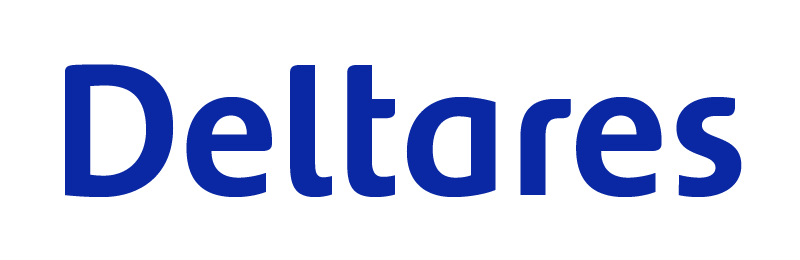

# Import modeldata and analysis

## Note beforehand

This is a modified version of the Jupyter notebook distributed during the iMOD
International days 2024. The modifications made to the original material mainly
make accessing the data required for the course easier. [To read the original
course material follow this
link.](https://deltares.thegood.cloud/s/o9ww4ZxZefd7BC5)


## Requirements

* Python environment with iMOD Python version > 0.18.0 
  <br> Start this notebook within a python
  environment where all required packages are installed. We suggest to use
  Deltaforge, a python distribution which includes iMOD Python and all its
  dependencies. Deltaforge is provided as an installer and makes installing
  iMOD Python easy. You can download the Deltaforge installer on the [Deltares
  download portal.](https://download.deltares.nl/imod-suite)

## Description

In this tutorial, you will learn how to use iMOD Python for building, running
and analysing your MODFLOW 6 model. We compiled a tutorial to help you get
started with iMOD Python and give you an overview of its capabilities.

In this Tutorial you learn how to:
1. load an existing model from a project file;
1. add your additional data for rivers;
1. allocate your rivers to the right model layer(s);
1. validate your model;
1. clean up your modeldata;
1. run your model;
1. view you results;
1. Extra options: 
1. (rescale to coarser grid).
1. (add well data).
1. (add horizontal flow barier).
1. (check the water balance).
1. (create an unstructured grid with Pahdamesh).
1. (regrid you model to an unstructured mesh).

We run this tutorial in a Jupyter notebook. You can run this cell by cell:
``[]`` means the cell is not run yet, ``[*]`` means the cell is currently
running, ``[1]`` means the cell is finished.
> Note: The cells where we run
  the simulation will take a few minutes.


# Introduction case Hondsrug

The "Hondsrug" a Dutch ridge of sand over a range of 70 km. It is the only
*geopark* in The Netherlands and part of Natura 2000, an European network of
protected areas. <br>

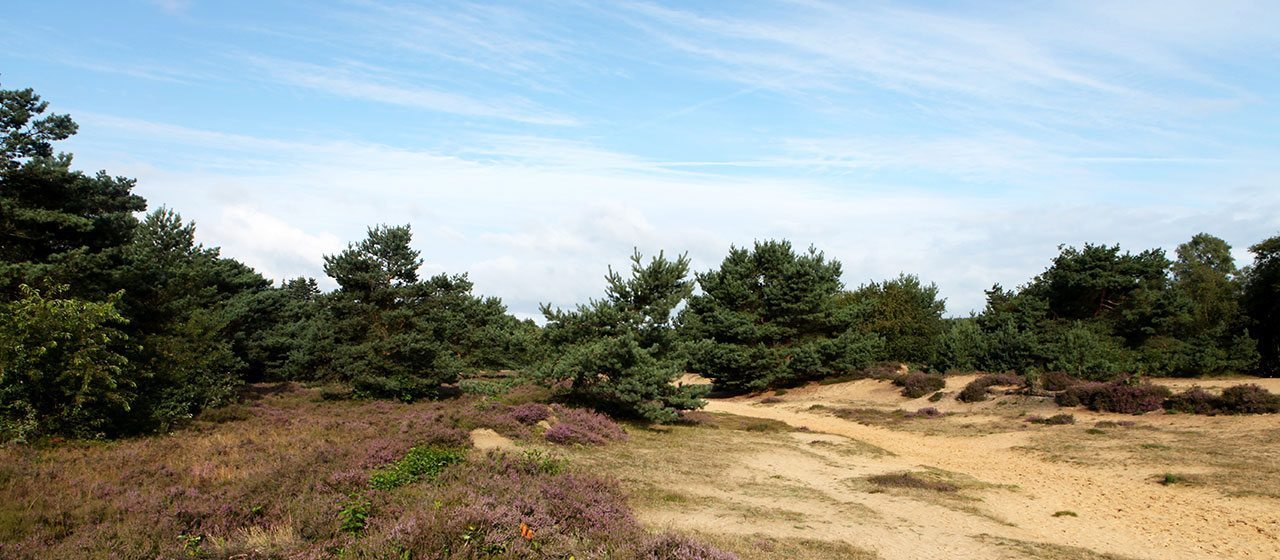

# Start of the iMOD python tutorial

We'll start off with importing iMOD Python. Therefore type ``import imod`` in
the next cell and run it.

In [2]:
import imod


From now on, all iMOD Python functions and classes are available. An important
one is the class ``imod.mf6.Modflow6Simulation``. An object from this class
can contain one ore more complete MODFLOW 6 models. For more MODFLOW 6
functions and classes check the [API Reference
website](https://deltares.gitlab.io/imod/imod-python/api/mf6.html#)



## Read simulation from iMOD5 project file (*.prj)

With iMOD Python you can of course create a MODFLOW 6 model from scratch. You can try that yourself in [Tutorial Hondsrug](https://deltares.github.io/iMOD-Documentation/tutorial_Hondsrug.html#). <br> It is also possible to read/import a model that was already created by the traditional version of iMOD; version iMOD5. 
To share these models, iMOD5 uses a PRJ file as model configuration file and *.IDF and *.IPF files for data. <br>
You find the PRJ file for this tutorial in the tutorial database named *"... tuturial_03\imod5\dbase\GWF_model_Hondsrug.prj".* <br>

To get there, lets first set the currect working directory. 
(we will import the package ``pathlib`` first.) 

In [81]:
from pathlib import Path
tutorialdir = pathlib.Path(r"c:\Users\roelofs_fs\OneDrive - Stichting Deltares\_projecten\imod\dsd\2024\training\tutorial_03")

Now we are ready to have a quick look at the content of this model configuration file. <br> Good to know: iMOD5 uses 1 file per parameter, per layer and per timestep. 
While the Hondsrug model is a 13 layer model, you will recognize date blocks for 13 layers. 

In [99]:
PRJname = tutorialdir / "GWF_model_Hondsrug.prj"
!notepad {PRJname}

You recognize Modflow input parameters like *Boundary Condition*, *Top* and *Bottom Elevation* and further down also *Rivers*.


Close the window of "GWF_model_Hondsrug.prj". <br> 
*(For more information on the PRJ file, download the [iMOD5 manual](https://content.oss.deltares.nl/imod/imod56/iMOD_User_Manual_V5_6.pdf) 
and check chapter "9.3 PRJ-files")*


We will use the iMOD Python function ``prj.open_projectfile_data`` to load this MODFLOW 6 model from the
PRJ file. <br> This returns a Python dictionary, so in memory, with all the basic data from the PRJ file. 

In [100]:
imod5_data, period_data = imod.prj.open_projectfile_data(PRJname)


Let's check the content of *imod5_data*. We skip *periode_data*. It is empty in this example because no time periods are defined. <br> 
*imod5_data* is a Pytyhon dictonary, so we can ask for the *keys*, the table of contents of this dictonary. <br>
Than you will see that the DRN is defined by 3 systems and RIV by 4.

In [114]:
imod5_data.keys()

dict_keys(['bnd', 'top', 'bot', 'khv', 'kva', 'shd', 'sto', 'rch', 'drn-1', 'drn-2', 'drn-3', 'drn-4', 'riv-1', 'riv-2', 'riv-3', 'riv-4', 'pcg'])

You are going to edit one of these packages later on. <br> 

Be aware that this dictionary can contain rasterdata for various xy-windows and with different cell size. <br>
So the next step is to use this basic data and transform it into a real *Modflow6Simulation object*. <br> 
That transformation is a complex process. It includes all kinds of scaling, clipping and application of nice transformation features that the iMOD5 executable provided. <br>

For this transformation we use the iMOD Python function ``Modflow6Simulation.from_imod5_data``. <br>
The function requires these settings:   
1. a definition of the time discretization of the model to be imported (specific for the WELL package) 
1. (default) allocation options per package type
1. (default) conductivity distribution options per package type

Let's define these 3 settings first:

In [127]:
# 1. definition of stress periods
import numpy as np
starttime = "2011-01-01"
endtime = "2012-01-01"
times=[np.datetime64(starttime),np.datetime64(endtime)]

# 2. get the default allocation options
from imod.prepare.topsystem.default_allocation_methods import SimulationAllocationOptions

# 3. get the default distribution options
from imod.prepare.topsystem.default_allocation_methods import SimulationDistributingOptions

## Transform iMOD5 model data into a MODFLOW6 simulation

Now we are ready to creat the *Modflow6Simulation object* from the iMOD5 data. You are free to pick a name, we call the simulation "sim_Hondsrug". <br>

In [128]:
sim_Hondsrug = imod.mf6.Modflow6Simulation.from_imod5_data(imod5_data,period_data,SimulationAllocationOptions,SimulationDistributingOptions,times)

We are almost ready to write and run the MODFLOW6 model. <br>
Last step is to:
- define the *time discretization* (stress periods). By default the timesteps of the transient input are taken. <br> 
We wil add an additional year to the simulation. 
- define what results we want to save tin the Output Control settings. 

In [135]:
# Set time discretisation
finaldate = "2013-01-01"
sim_Hondsrug.create_time_discretization(additional_times = [np.datetime64(finaldate)])

# Define the required output parameters
sim_Hondsrug["imported_model"]["oc"] = imod.mf6.OutputControl(save_head="all", save_budget="last")

Let's see what is in this *Modflow6Simulation object* by just typing the name of the object.

In [131]:
sim_Hondsrug

Modflow6Simulation(
    name='imported_simulation',
    directory=None
){
    'imported_model': GroundwaterFlowModel,
    'ims': Solution,
    'time_discretization': TimeDiscretization,
}

From this echo it is clear that *sim_Hondsrug*: 
- it is a Modflow6Simulation object
- the simulation contains a Groundwater Flow (GWF) model\*
- the name of the GWF is 'imported_simulation'

*\* other options are e.g. Groundwater Transport (GWT) model and Groundwater Energy (GWE) model*

In [ ]:
# Frans: tijdelijke fix in version 0.18.0
dis = sim_Hondsrug["imported_model"]["dis"]
dis["idomain"] = dis["idomain"].where(dis["idomain"] != 0, -1)

## Running the MODFLOW 6 simulation

Now it's time to run the MODFLOW 6 simulation. This takes a few minutes.
1. First we define a result folder.
1. Then we write the MODFLOW 6 input file, so the mfsim.nam file and all other package input files
1. Finally we run the model with the MODFLOW 6 executable.

By default the model is saved and run in a temporal directory. Feel free to give a foldername of your choise. <br>
With a simple ``.write`` statement the native MODFLOW6 files are writen. This might take some 10-15 seconds.

In [133]:
# 1. define the results folder
resultdir = tutorialdir / "results" / "reference"
# 2. write the MODFLOW6 input files
sim_Hondsrug.write(resultdir, binary=False)

Now we can refer to the MODFLOW6 executable and start the simulation.

In [134]:
# define path of your MODFLOW 6 executable
mf6= tutorialdir / "bin" / "MODFLOW6_v6.4.2.exe" 

# Run your model
sim_Hondsrug.run(mf6)

The model is ready but did it run correctely? <br>
Always check the file "mfsim.lst". See if it exists and if the last line reads ``Normal termination of simulation``.

In [137]:
LSTname = resultdir / "mfsim.lst"
!notepad {LSTname}

In [6]:
riv_pkg = gwf_model["riv"]


This riv_pkg is just the river *object*. To actually access the data in this
package, we use the ``dataset`` attribute. This returns an xarray Dataset
which is the important data structure on which iMOD Python is built. If you
want to read more about these objects, [see the xarray documentation
here.](https://docs.xarray.dev/en/stable/user-guide/data-structures.html#dataset)


In [7]:
riv_pkg

River
<xarray.Dataset> Size: 5MB
Dimensions:           (x: 500, y: 200, layer: 4)
Coordinates:
  * x                 (x) float64 4kB 2.375e+05 2.375e+05 ... 2.5e+05 2.5e+05
  * y                 (y) float64 2kB 5.64e+05 5.64e+05 ... 5.59e+05 5.59e+05
    dx                float64 8B ...
    dy                float64 8B ...
  * layer             (layer) int32 16B 1 3 5 6
Data variables:
    stage             (layer, y, x) float32 2MB nan nan nan nan ... nan nan nan
    conductance       (layer, y, x) float32 2MB nan nan nan nan ... nan nan nan
    bottom_elevation  (layer, y, x) float32 2MB nan nan nan nan ... nan nan nan
    print_input       bool 1B False
    print_flows       bool 1B False
    save_flows        bool 1B False
    observations      object 8B None
    repeat_stress     object 8B None


You can see that it is indeed an xarray Dataset. You also see that this river
package has data on three *Dimensions*: x, y and layer. From the *Coordinates*
list you can read that there is data defined on 4 layers, namely: 1, 3, 5, 6.
<br> The *Data variables* section show that data is available for the 3
parameters required for the river package: "stage", "conductance" and
"bottom_elevation".


By the way, what is actually the number of layers in our model? <br> From all
MODFLOW 6 packages, only DIS, NPF and STO are defined for all layers. So in
one of those packages you find your answer. <br>
Assignment: "Find the total number of layers in our model from one of these packages"

In [8]:
# type your command here.....


Now we return to our river package, available in "riv_pkg". We can select the
stage information in layer 1 as follows:

* select variable "stage" from the Dataset;
* and select only the "stage" values for the 1st layer.

In [9]:
riv_stage_layer_1 = riv_pkg["stage"].sel(layer=1)


The result is a 2 dimensional (x/y) xarray Dataset. We can have a look at the
content by just typing the object name.

In [10]:
riv_stage_layer_1

<xarray.DataArray 'stage' (y: 200, x: 500)> Size: 400kB
array([[ nan,  nan,  nan, ..., 1.39, 1.36, 1.34],
       [ nan,  nan,  nan, ...,  nan, 1.34, 1.34],
       [ nan,  nan,  nan, ...,  nan, 1.03, 0.8 ],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)
Coordinates:
  * x        (x) float64 4kB 2.375e+05 2.375e+05 2.376e+05 ... 2.5e+05 2.5e+05
  * y        (y) float64 2kB 5.64e+05 5.64e+05 5.639e+05 ... 5.59e+05 5.59e+05
    dx       float64 8B ...
    dy       float64 8B ...
    layer    int32 4B 1


## Plot model parameters

An xarray Dataset has plot functionalities included. This makes it easy to get
an impression of the spatial distrubution of our stage values for layer 1.
<br> In the next cell just type the name of 2D Dataset you just created
including the call for the plot function ``.plot()``. %% replace with your
plot command


Congratulations, your first picture in this tutorial! <br> Instead of this
default plot option, we can plot this stage data also on a map with the iMOD
Python function
[imod.visualize.plot_map](https://deltares.gitlab.io/imod/imod-python/examples/visualize/plot_map.html#sphx-glr-examples-visualize-plot-map-py).

We'll start off by defining a colormap and levels for the legend.

In [11]:
import numpy as np

colors = "Blues"
levels = np.arange(-2.5, 18.5, 2.5)


With this colormap, the legend range and the 2d Dataset, we call the iMOD
Python plot_map function:

(<Figure size 640x480 with 2 Axes>, <Axes: >)

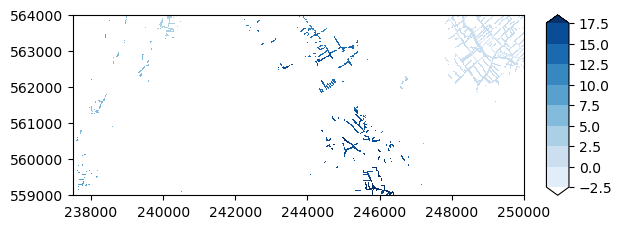

In [12]:

imod.visualize.plot_map(riv_stage_layer_1, colors, levels)


As you can see [imod.visualize.plot_map](
https://deltares.gitlab.io/imod/imod-python/examples/visualize/plot_map.html#sphx-glr-examples-visualize-plot-map-py)
preserves the aspect ratio, whereas the ``.plot`` method stretches the figure
in the y-direction to make a square figure.


Try plotting with a different colormap. For all possible colormaps, see the
[Matplotlib
page](https://matplotlib.org/stable/users/explain/colors/colormaps.html). For
instance pick colormap "viridis".

(<Figure size 640x480 with 2 Axes>, <Axes: >)

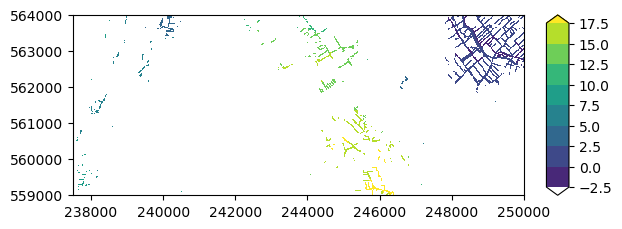

In [13]:
colors = "viridis"  # specify your color here

imod.visualize.plot_map(riv_stage_layer_1, colors, levels)


We can add a background map to this plot for a better orientation. Therefore
we need to import the package `contextily` first. This opens a wide range of
possible basemaps, [see the full list
here.](https://contextily.readthedocs.io/en/latest/intro_guide.html#Providers>)
* Next step is to define our background_map, in this example it is one of the OpenStreetMap variants.
* The we add this basemap as argument to our plot function.

(<Figure size 640x480 with 2 Axes>, <Axes: >)

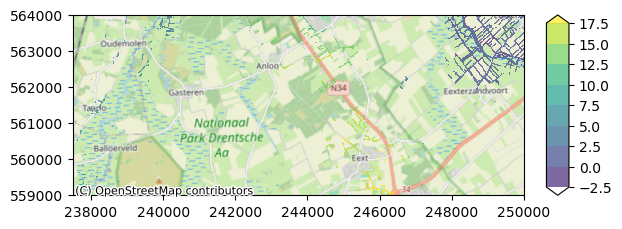

In [14]:
import contextily as ctx

# Access background maps
background_map = ctx.providers["OpenStreetMap"]["Mapnik"]

# Add background map to your plot
imod.visualize.plot_map(riv_stage_layer_1, colors, levels, basemap=background_map)


Assignment: in the next cell, try to visualize the bottom elevation of layer
  3.

In [15]:
#
# type here you python commands to select and plot bottom data for layer 3


It can be convenient to combine the rivers over all layers into one map. You
can aggregate layers using [xarrays
aggregation](https://docs.xarray.dev/en/stable/user-guide/computation.html#aggregation)
functionality. For example we can compute the mean of the river stage across
all layers:

(<Figure size 640x480 with 2 Axes>, <Axes: >)

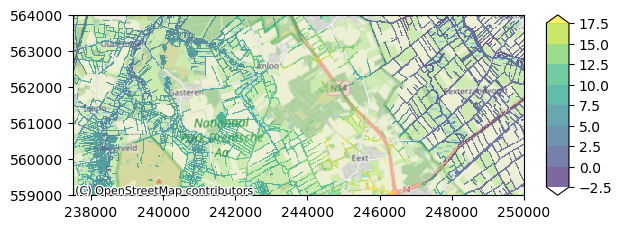

In [16]:
riv_all = riv_pkg["stage"].mean(dim="layer")

imod.visualize.plot_map(riv_all, colors, levels, basemap=background_map)


# Running the simulation

Now it's time to run the MODFLOW 6 simulation.
1. First we create a result folder.
1. Then we write the MODFLOW 6 input file, so the mfsim.nam file and all other package input files
1. Finally we run the model with the MODFLOW 6 executable.
Now it's time to run the simulation. This takes a few minutes.

Step 1. To create a result folder, we will import the package ``pathlib`` first. The name of the  result folder for this initial model is "reference".

In [17]:
# Define the project directory where you want to write and run the Modflow 6
# simulation.
prj_dir = tmpdir / "results"

modeldir = prj_dir / "reference"


Step 2. You remember the MODFLOW 6 model object "simulation" that contained
our full MODFLOW 6 model. This object has the function ``.write``. The
function converts the model to native MODFLOW 6 input files, so the mfsim.nam
file and all other package files like *.dis, *.drn and *.riv.

In [18]:
# Write the MODFLOW 6 simulation files from the model object
simulation.write(modeldir)


In your file manager check if the MODFLOW 6 files are created in your result
folder, e.g. NAM file
"c:\imod\dsd\2023\training\dsd-2023\results\reference\GWF\GWF.nam"


Step 3 is to run the run our model with the MODFLOW 6 executable. Therefore we
use the function ``.run`` from our model object "simulation". The only
parameter is the path name of the MODFLOW 6 executable. <br>

**NB** Before you run the simulation, provide the function the correct path to
the MODFLOW 6 executable. <br>
**NB** The run takes a few minutes.

In [19]:
# mf6_path = "path/to/mf6.exe" 

# If you installed Modflow6 in your PATH environment variable, you can use the
# following argument:
mf6_path = "mf6"

simulation.run(mf6_path)

FileNotFoundError: [WinError 2] The system cannot find the file specified


# Exploring the results

We can open the heads with the ``.open_head`` method. This automatically finds
the appropriate files to open the model output.

The calculated heads are saved in the file "GWF/GWF.hds". In order to
display these results spatially correct, the values must be plotted on the
corrrect grid topology. The grid of our model is available in the Binary Grid
file "GWF/dis.dis.grb". 

In [ ]:
calculated_heads = simulation.open_head()

Let's check the content of this xarray Dataset.

In [ ]:
calculated_heads


This dataset contains calculated heads for all 13 layers. For the first time
we see that our full model contains also 7 stress periods: *time:7*. <br> We
can select heads for all layers at the final timestep with the ``.isel``
function, meaning a selection based on index number.

In [ ]:
heads_end = calculated_heads.isel(time=-1)

heads_end


Let's plot the heads for layer 3 only. Use the function ``.plot_map`` as we
did before. Be aware that instead of using the ``.isel`` function, we now use
``.sel``. Within xarray this is a selection based on index *name* instead of
index *numer*.

In [ ]:
imod.visualize.plot_map(heads_end.sel(layer=3), colors, levels, basemap=background_map)


As you can see layer 3 has some missing cells in the west. Whereas layer 4
only contains active cells in the eastern peatland area.

Assignment: add your plot command for layer 4 in the cell below.

In [ ]:
# type your command here.....
# TODO remove example
imod.visualize.plot_map(heads_end.sel(layer=5), colors, levels, basemap=background_map)


Layer 5 contains more data towards the west, but has no active cells in the
centre.

In [ ]:
# type your command here.....
# TODO remove example
imod.visualize.plot_map(heads_end.sel(layer=5), colors, levels, basemap=background_map)


As you can see the data is individual layers have lots of inactive cells in
different places. It is difficult for this model to get a good idea what is
happening across the area based on 1 layer alone. Luckily xarray allows us to
compute the mean across a selection of layers by first selecting 3 layers
(first aquifer) with ``.sel``, and then computing the mean across the layer
dimension. <br>

We can do that in 2 lines of code: <br>
``head_end_3layers = heads_end.sel(layer=slice(3, 5))`` <br>
``head_end_aq1 = head_end_3layers.mean(dim="layer")`` <br>
Or we can concatenate both steps to one:

In [ ]:
head_end_aq1 = heads_end.sel(layer=slice(3, 5)).mean(dim="layer")

imod.visualize.plot_map(head_end_aq1, colors, levels, basemap=background_map)

# Adding a well

Let's add an extraction well at x=246000 and y=560000. Therefore we create a
well object first. We use variables *x_well* and *y_well* to define the
location so we can reuse the variables later on. We can provide a well screen
top and bottom and iMOD Python automatically places the well in the right
layer(s) upon writing the model.

In [ ]:
x_well = 246000.0
y_well = 560000.0
# create a well object
well = imod.mf6.Well(
    screen_top=[-13.0],
    screen_bottom=[-50.0],
    y=[y_well],
    x=[x_well],
    rate=[-60000.0],
)


Next step is to add your well (object) to the existing groundwater model
"GWF".

In [ ]:
simulation["GWF"]["wel"] = well


Interested to see if the package was added correctely? <br> Get the list of
available package by adding the command ``gwf_model`` in the cell above and
run the cell again.



We are ready to rerun the model and check the drawdown effect of the well.
Do you recall the steps we took in order to get the mean head for layers 1 to 3? <br>
Step 1: define the result folder and run the model.  <br>
Step 2: read the calculated heads.  <br>
Step 3: select the last stressperiod and average over layers 1 to 3.

In the next cell, give this scenario run a name:

In [ ]:
# Step 1: run the model
modeldir = prj_dir / "extraction"
simulation.write(modeldir)
simulation.run(mf6_path)

In [ ]:
# Step 2: export the calculated heads

heads_with_well = simulation.open_head()

heads_with_well

In [ ]:
# Step 3: select the last stressperiod and average over layers 1 to 3.
heads_with_well_end = heads_with_well.isel(time=-1)
heads_with_well_end_aq1 = heads_with_well_end.sel(layer=slice(3, 5)).mean(dim="layer")

### Compute differences
Let's compare differences between the two scenarios, by computing
difference in heads and plot this on a map.

In [ ]:
# Calculate the head difference.
diff = heads_with_well_end_aq1 - head_end_aq1

# Plot the result

In [ ]:

colors = "Blues"
levels = np.arange(-2.5, 18.5, 2.5)

imod.visualize.plot_map(diff, colors, levels, basemap=background_map)


With this legend, we can not see the impact of the well effect enough. We need
another legend; both anouther color range and another range of values. <br>
Assignment:
- make the levels range from -10 to 0 meter with steps of 1 meter.
- choose "hot" for colorbar

In [ ]:
# levels = ?
# colors = ?
# TODO: onderstaande regels verwijderen
levels = np.arange(-10.0, 0.0, 1.0)
colors = "hot"
imod.visualize.plot_map(diff, colors, levels, basemap=background_map)

# Adding recharge

The model read from the toml file contains already some transient recharge
that we are going to replace. But first check the figure below and see the
mean at 31 December 2014.

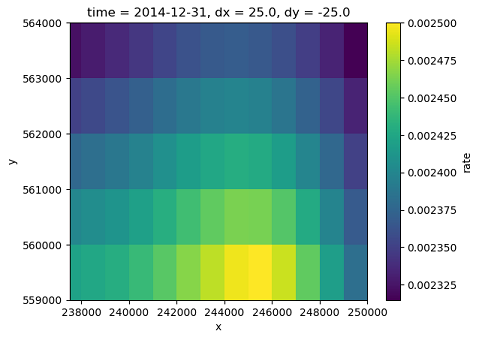
figure: mean recharge on 31-12-2014


Do you think you can plot this figure yourself now you have some experience?
<br>
Assignment: apply correct methods for *time* and *layer* to the dataset
``simulation["GWF"]["rch"]["rate"]`` and plot your figure.

In [ ]:
# add functions
# simulation["GWF"]["rch"]["rate"]..........


Now we open the dataset with the xarray function into variable 'meteorology'.

In [ ]:
meteorology = imod.data.hondsrug_meteorology()


Next step is to check the content of the dataset. See that is contains spatial
data from 1999-01-01 till 2020-04-09. <br> *For which 2 variables data is
stored in the file?*

In [ ]:
meteorology

In [ ]:
# A plot of the evapotranspiration at 202-04-09.
meteorology.isel(time=-1)["evapotranspiration"].plot()


If you look carefully, you can see that the unit of this dataset is in mm/d.
Our MODFLOW 6 model is defined in m/d, so we'll have to convert units here.
Xarray allows you to do computations on complete datasets, so we can divide
both the precipitation and the evapotranspiration by 1000.0.

In [ ]:
meteorology = meteorology / 1000.0


For your own reference (and your colleagues), it is wise to update the units
in the attributes of the dataset

In [ ]:
meteorology.attrs["units"] = "m/d"

meteorology


We'll compute the recharge very rudimentarily by subtracting the precipitation
from the evapotranspiration.

In [ ]:
recharge = meteorology["precipitation"] - meteorology["evapotranspiration"]


For the steady state conditions of the model, the data from the period 2000 to
2009 is considered as reference. The initial information must be sliced to
this time period and averaged to obtain the a mean value grid. <br>


Assignment: fill in the start and end data for our reference period using
yyyy-mm-dd.

In [ ]:
# slice recharge based on date
recharge_first_decade = recharge.sel(time=slice("2000-01-01", "2009-12-31"))
# calculate the steady state recharge
recharge_steady_state = recharge_first_decade.mean(dim="time")

In [ ]:
# redefine the legend values
levels = np.arange(0.0, 0.0011, 1e-4)

# plot with color bar "blues"
imod.visualize.plot_map(recharge_steady_state, "Blues", levels, basemap=background_map)


Finding the right levels for this plot can be cumbersome. So we can define a
function to compute appropriate levels for the plot based on a given DataArray
and a desired number of legend levels.

In [ ]:
def compute_levels(da, N):
    """
    This function computes N levels based on the range of a provided DataArray "da".

    Parameters
    ----------
    da: xr.DataArray
        The DataArray for which a number of levels needs to be computed
    N: int
        The number of levels
    """
    levels = np.linspace(da.min(), da.max(), N)
    return levels


# call to the function for a 10 level legend
levels = compute_levels(recharge_steady_state, 10)
# plot the recharge figure
imod.visualize.plot_map(recharge_steady_state, "Blues", levels, basemap=background_map)

## Aligning the recharge data over time

The recharge data has quite a lot of timesteps: data on a daily timestep for
over 20 years from 1999 to 2020.

In [ ]:
recharge.coords["time"]


This is entirely different from our model discretization as you can see from
the next command. It is on a yearly timestep and lasts from 2010 to 2015.

In [ ]:
simulation["time_discretization"]["time"]


We therefore need to align this data over time. We'll start off by selecting
the data in this time range.

In [ ]:
recharge_daily = recharge.sel(time=slice("2010-01-01", "2015-12-31"))

recharge_daily


Xarray has functionality to resample recharge to yearly timestep ("A" stands
for "annum"). [If you want to find the aliases for other frequencies, see this
table
](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)
We'll label the years with their starting point, as iMOD Python defines its
stress periods on their starting moment.

In [ ]:
recharge_yearly = recharge_daily.resample(time="A", label="left").mean()

recharge_yearly


To visually compare the effects of the yearly versus daily recharge, we can
make a lineplot. For there plot functionalities we need to import the package
``matplotlib`` one-time. We'll take a point close to the well. We can use:

In [ ]:
import matplotlib.pyplot as plt

# initialization of the figure and single graph
fig, ax = plt.subplots()
# defining the content of the graph
recharge_daily.sel(x=x_well, y=y_well, method="nearest").plot(ax=ax)
recharge_yearly.sel(x=x_well, y=y_well, method="nearest").plot(ax=ax)
# display the graph
plt.show()


To create the final recharge for the transient simulation, the steady state
information needs to be concatenated to the transient recharge data. The
steady state simulation will be run for one second. This is achieved by using
the numpy [Timedelta
function](https://numpy.org/doc/stable/reference/arrays.datetime.html), first
creating a time delta of 1 second, which is assigned to the steady-state
recharge information. This dataset is then concatenated using the xarray
function
[xarray.concat](http://xarray.pydata.org/en/stable/generated/xarray.concat.html#xarray.concat)
to the transient information and indicating that the dimension to join is
``"time"``.

In [ ]:
import xarray as xr

starttime = "2009-12-31"

# create second before transient
one_second = np.timedelta64(1, "s")  # 1 second duration for initial steady-state
starttime_ss = np.datetime64(starttime) - one_second
# fill in with steady-state value
recharge_steady_state = recharge_steady_state.assign_coords(time=starttime_ss)
# add before transient data
recharge_ss_yearly = xr.concat([recharge_steady_state, recharge_yearly], dim="time")
# check timesteps
recharge_ss_yearly.coords["time"]


The Recharge package requires a layer coordinate to assign values to. We'll
assign all values to the first layer.

In [ ]:
recharge_ss_yearly = recharge_ss_yearly.assign_coords(layer=1)
# see that coordinate "layer" is added
recharge_ss_yearly


Furthermore, iMOD Python expects its data to follow the dimension order:
``["time", "layer", "y", "x"]``. The recharge data has order ``["y", "x",
"time"]`` after concatenation.

In [ ]:
recharge_ss_yearly = recharge_ss_yearly.transpose("time", "y", "x")

recharge_ss_yearly


We'll assign the recharge to recharge package.

In [ ]:
recharge_pkg_coarse = imod.mf6.Recharge(rate=recharge_ss_yearly)

recharge_pkg_coarse


This recharge package is defined on a coarse grid and not the model grid. iMOD
Python has functionality ``regrid_like`` to regrid model packages to the
appropriate grid. We'll use the first layer of the idomain in our model as the
template grid.

Note that we create a RegridderWeightsCache here. This will store the weights of
the regridder. Using the same cache to regrid another package will lead to a
performance increase if that package uses the same regridding method, because
initializing a regridder is costly.


In [ ]:
from imod.mf6.utilities.regrid import RegridderWeightsCache

template_grid = gwf_model["dis"]["idomain"].sel(layer=1)

regrid_context = RegridderWeightsCache()
recharge_pkg = recharge_pkg_coarse.regrid_like(template_grid, regrid_context)

recharge_pkg


MODFLOW 6 does not accept recharge cells which are assigned to inactive cells
(where ``idomain != 1``). iMOD Python therefore has convenience functions to
get the upper active layer

In [ ]:
from imod.prepare import get_upper_active_grid_cells

# Select the grid cells where idomain == 1, these are the active cells.
idomain = gwf_model["dis"]["idomain"]
is_active = idomain == 1
# Find the upper active cells
is_upper_active_grid = get_upper_active_grid_cells(is_active)
# We can use xarrays where method to broadcast the recharge rates to the upper
# active cells.
recharge_pkg["rate"] = recharge_pkg["rate"].where(is_upper_active_grid)
# Finally reorder the dimensions of the dataset to how it is expected by iMOD
# Python.
recharge_pkg.dataset = recharge_pkg.dataset.transpose("time", "layer", "y", "x")

recharge_pkg


We'll override the recharge package with our newly computed recharge package

In [ ]:
gwf_model["rch"] = recharge_pkg


Write the simulation and run it again

In [ ]:
modeldir = prj_dir / "new_recharge"
simulation.write(modeldir)
simulation.run(mf6_path)

In [ ]:
# Open heads
head_new_recharge = simulation.open_head()

head_new_recharge

In [ ]:

diff_new_rch = head_new_recharge - calculated_heads

diff_new_rch_end_first_aqf = (
    diff_new_rch.isel(time=-1).sel(layer=slice(3, 5)).mean(dim="layer")
)

levels = np.arange(-10.0, 0.0, 1.0)

imod.visualize.plot_map(
    diff_new_rch_end_first_aqf, "hot", levels, basemap=background_map
)

# Create a cross-section
Making a cross-section is rather easy in iMOD Python. We can use the function [imod.select.cross_section_linestring](https://deltares.gitlab.io/imod/imod-python/api/generated/select/imod.select.cross_section_linestring.html#imod-select-cross-section-linestring).
Furthermore we only need gridded data and a line to slice through the data. For this tutorial let's make a cross-section and display the permeability of the layers.
* First we create a geology data set with the "permeability" and of course the 'top' and 'bottom' of all the layers.
* Then we slice the data set with a line and plot the result.

## Create geology dataset
The "permeability" of the model is available in the "npf" package of our model. So we start to fill a new "geology" dataset with this "k" value.

In [ ]:
geology = gwf_model["npf"]["k"]

The "top" and "bottom" information of layers is available in the "dis" package. Unfortunately the "dis" package has bottom information for all layers but only top information for layer 1. Check this in the next cell.

In [ ]:
gwf_model["dis"]

So first we add the bottom information to our geology dataset.

In [ ]:
geology["bottom"] = gwf_model["dis"]["bottom"]

Then we define the top of layer 1 to be the Digital Elevation Model (DEM).
Next, for layer 2 to 13, we must fill in the top of each layer
with the bottom of the layer above (e.g. top_l5 = bot_l4).
Seems like a bit complicated? No, we can use the ``.shift`` function of xarray for this.

In [ ]:
DEM = gwf_model["dis"]["top"]
geology["top"] = geology["bottom"].shift(layer=1).fillna(DEM)

# Check the content of geology data set
geology

Let's plot the top of our model, the DEM.

In [ ]:
levels = compute_levels(DEM, 10)
imod.visualize.plot_map(DEM, "viridis", levels, basemap=background_map)

## Plot cross-section
The geology is ready so the last element we need is the cross-section line. In the data set the Esri Shape "crosssection.shp" is available. We need the package ``geopandas`` to read the file into a GeoDataFrame object.

In [ ]:

crossline = imod.data.hondsrug_crosssection(tmpdir / "cross-section")

We can plot our DEM again and add our cross-section line as an overlay to our function ``plot_map``.

In [ ]:
# define overlay
overlays = [{"gdf": crossline, "edgecolor": "black",  "linewidth":3}]
# Plot
imod.visualize.plot_map(DEM, "viridis", levels, overlays, basemap=background_map)

In the next cell we call the function ``cross_section_linestring`` together with our geology dataset and the geometry of our line. The result is a 2D DataArray "cross_k" with k-values along the line for all layers. We can plot this DataArray with the visualization function ``cross_section``.

In [ ]:
cross_k = imod.select.cross_section_linestring(geology, crossline.geometry[0])
levels = np.arange(0.0, 30.0, 5)
colors = "viridis"
imod.visualize.cross_section(cross_k, colors, levels)

With the package ``shapely`` you can easily make new geometries by hand for displaying other cross-sections. The next example is a new line from North to South over the area. You can play around with lines, colors and levels.

In [ ]:
from shapely.geometry import LineString

geometry = LineString([[244000,563000],[244000 ,559000]])
cross_k = imod.select.cross_section_linestring(geology, geometry)
imod.visualize.cross_section(cross_k, colors, levels)


# Model partitioning

We can partition our simulation into multiple sub-models. This is useful for
parallel computation. We need to specify the different domains to iMOD Python
by providing a grid with each subdomain labeled with a unique number. To
create 4 submodels (required to compute on 4 cores in parallel), we can
manually create this grid as follows:

In [ ]:

from imod.mf6.multimodel.partition_generator import get_label_array

npartitions = 4
submodel_labels = get_label_array(simulation, npartitions=npartitions)


# Plot the submodel labels
label_levels = np.arange(npartitions)

imod.visualize.plot_map(
    submodel_labels,
    "viridis",
    label_levels,
    basemap=background_map,
)


We consequently partition our simulation as follows with the split function:

In [ ]:
simulation_split = simulation.split(submodel_labels)

simulation_split


Notice the presence of the 4 groundwater flow models! Let's run them:

In [ ]:
modeldir = prj_dir / "partitioning"
simulation_split.write(modeldir)
simulation_split.run(mf6_path)


Modflow 6 writes heads for each partition seperately. It is more convenient to
merge these heads into one grid again, which we can compare with the original
grid. Luckily, the ``open_head`` function automatically merges heads for us.

In [ ]:
head_split = simulation_split.open_head()["head"]

head_split


For the final plot, it is good to have the submodel partitions as an overlay
over our plot. The ``plot_map`` function has an ``overlays`` argument which we
can use to plot overlays on our map. [See also this example how you can apply
this](https://deltares.gitlab.io/imod/imod-python/examples/visualize/plot_map.html).
This requires polygons though, and we have a raster. [We can polygonize our
raster with the ``imod.prepare.polygonize`` utility
function](https://deltares.gitlab.io/imod/imod-python/examples/prepare/polygonize_raster.html):

In [ ]:
submodel_polygons = imod.prepare.polygonize(submodel_labels)

submodel_polygons


Next we will plot the splitted output same as before. Notice that we have to
provide the overlays with a dictionary, in which we can specify some extra
settings. In this case, we do not want the polygons colored, but only the
edges of the polygons colored. We can do this as follows:

In [ ]:
overlays = [{"gdf": submodel_polygons, "edgecolor": "black", "facecolor": "None"}]

diff_split = head_split - calculated_heads

diff_split_end_first_aqf = (
    diff_split.isel(time=-1).sel(layer=slice(3, 5)).mean(dim="layer")
)

levels = np.arange(-10.0, 0.0, 1.0)

imod.visualize.plot_map(
    diff_split_end_first_aqf, "hot", levels, basemap=background_map, overlays=overlays
)


# Extra exercise

The yearly recharge did not differ much over time. Try computing your model on
monthly timestep below!

In [ ]:

fig, ax = plt.subplots()
# defining the content of the graph
recharge_daily.sel(x=x_well, y=y_well, method="nearest").plot(ax=ax)
recharge_yearly.sel(x=x_well, y=y_well, method="nearest").plot(ax=ax)
# display the graph
plt.show()


## Tips

* You can use the ``resample`` method to go from daily recharge to monthly recharge.
* [The table with aliases for frequencies can be found
  here.](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)
* Follow the consequent steps you did previously on your dataset to construct
  a Recharge package accepted by iMOD Python.
* You have to create a new time discretization for your simulation, as the
  original simulation has yearly stress periods. You can use the
  [create_time_discretization](https://deltares.gitlab.io/imod/imod-python/api/generated/mf6/imod.mf6.Modflow6Simulation.create_time_discretization.html)
  method for this.